#### Xuechun Wang
##### 24107190
##### STATS507 PS3

In [1]:
import pandas as pd
import numpy as np
import os
import requests
import math
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.colors import colorConverter as cc
from urllib import request

### Question 0 - RECS and Replicate Weights

##### Data Files

In [2]:
recs2015 = pd.read_csv("https://www.eia.gov/consumption/residential/data/2015/csv/recs2015_public_v4.csv")
recs2009 = pd.read_csv("https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv")
recs_weight = pd.read_csv("https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public_repweights.csv")

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (717,718) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


##### Variables

 - "DOEID": **-numeric-** Unique identifier for each respondent
 - "NWEIGHT": **-numeric-**Final sample weight
 - "REGIONC": **-categorical-**Census Region
 - "CDD30YR": **-numeric-**Cooling degree days, 30-year average 1981-2010, base temperature 65F
 - "CDD65": **-numeric-**Cooling degree days in 2015, base temperature 65F
 - "CDD80": **-numeric-**Cooling degree days in 2015, base temperature 80F
 - "HDD30YR":**-numeric-**Heating degree days, 30-year average 1981-2010, base temperature 65F
 - "HDD65":**-numeric-**Heating degree days in 2015, base temperature 65F
 - "HDD50": **-numeric-**Heating degree days in 2015, base temperature 50F<br>
 
 
 - **we may only use CDD65 an HDD65 for calculations in the Question 2 which contain the true meaning toward the variance calculation**
 - **The CDDxx and HDDxx is still used in Question 1, but it is just for constructing dataframe and will not influence the question**

##### Weights and Replicate Weights

**2015GuideBook**:[Compute Estimate and Standard Errors](https://www.eia.gov/consumption/residential/data/2015/pdf/microdata_v3.pdf).<br>

**2009GuideBook**:[Compute Estimate and Standard Errors](https://www.eia.gov/consumption/residential/methodology/2009/pdf/using-microdata-022613.pdf).

The **standard error** is calculated by applying Fay's method of balanced repeated replication (BRR) to estimate the statistic of interest repeatly and find the differences from the full-sample estimate.<br>

**$\theta$** refers to the population parameter of interest and let **$\hat{\theta}$** be the estimate from the full sample of $\theta$. <br>

Fay coefficient, $\epsilon$, a range in-between $0\le\epsilon\lt1$.<br>
In this scenario, $\epsilon$ refers to 0.5 for both 2009 and 2015 cases.<br>


Let $\hat{\theta_r}$ be the **estimate** from the r-th replicate subsample by using replicate weights.<br>

**r** refers to the **sample order of the replicate weights**; In 2015, there are 96 BRRWT replicate weights from 1st to 96th, while in 2009, there are 244 BRR replicate weights from 1st to 244th. They are used later in calculating standard error of replicates weights from full sample weights.

The **variance** of $\hat{\theta}$ is <br>

$\hat(\theta) = \frac{1}{R(1-\epsilon)^2}\sum_{r=1}^R(\hat{\theta_r} - \hat{\theta})^2$

#### Question 1 - Data Preparation

In [3]:
#Check if file exists in the local
path1 = '/Users/Sylvia/Desktop/recs2015_public_v4.csv'
path2 = '/Users/Sylvia/Desktop/recs2009_public.csv'
path3 = '/Users/Sylvia/Desktop/recs2009_public_repweights.csv'
is_exists1 = os.path.exists(path1)
is_exists2 = os.path.exists(path2)
is_exists3 = os.path.exists(path3)
if is_exists1 == True:
    recs2015 = pd.read_csv(path1)
else:
    recs2015 = pd.read_csv("https://www.eia.gov/consumption/residential/data/2015/csv/recs2015_public_v4.csv")
if is_exists2 == True:
    recs2009 = pd.read_csv(path2)
else:
    recs2009 = pd.read_csv("https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv")
if is_exists3 == True:
    recs_weight = pd.read_csv(path3)
else:
    recs_weight = pd.read_csv("https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public_repweights.csv")

##### part a)

In [4]:
#Extract columns from dataset
recs2015_v = recs2015[['DOEID','NWEIGHT','REGIONC','CDD30YR', 'CDD65', 'CDD80', 'HDD30YR','HDD65','HDD50']]

In [5]:
#Rename columns
recs2015_v.rename(columns = {"DOEID": "id","NWEIGHT":"samp_wei",
                             "REGIONC":"census_re"}, inplace = True)
recs2015_v.rename(columns = {"CDD30YR": "cd_30yrs",
                             "CDD65":"cd65","CDD80":"cd80"}, inplace = True)
recs2015_v.rename(columns = {"HDD30YR": "hd_30yrs",
                             "HDD65":"hd65","HDD50":"hd50"}, inplace = True)
recs2015_v

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,id,samp_wei,census_re,cd_30yrs,cd65,cd80,hd_30yrs,hd65,hd50
0,10001,12085.16227,4,1332,1768,118,2640,2031,213
1,10002,14410.19627,3,2494,2795,417,2178,1915,466
2,10003,23325.95385,3,2059,2235,126,2714,2263,634
3,10004,12165.33319,2,1327,1374,63,4205,3754,1321
4,10005,16717.67092,1,871,993,9,5397,5401,2462
...,...,...,...,...,...,...,...,...,...
5681,15682,14190.77054,2,735,632,38,6692,6470,3110
5682,15683,13617.68710,3,1697,2055,55,2842,2512,886
5683,15684,20365.17745,2,997,937,16,6214,5941,2962
5684,15685,15110.19635,3,2923,3464,613,1567,1438,268


In [6]:
#Substitute categorical data
categ_name = {"census_re":{1:"Northeast", 2: "Midwest", 3: "South", 4: "West"}}
recs2015_v = recs2015_v.replace(categ_name)
recs2015_v

,id,samp_wei,census_re,cd_30yrs,cd65,cd80,hd_30yrs,hd65,hd50
0,10001,12085.16227,West,1332,1768,118,2640,2031,213
1,10002,14410.19627,South,2494,2795,417,2178,1915,466
2,10003,23325.95385,South,2059,2235,126,2714,2263,634
3,10004,12165.33319,Midwest,1327,1374,63,4205,3754,1321
4,10005,16717.67092,Northeast,871,993,9,5397,5401,2462
...,...,...,...,...,...,...,...,...,...
5681,15682,14190.77054,Midwest,735,632,38,6692,6470,3110
5682,15683,13617.68710,South,1697,2055,55,2842,2512,886
5683,15684,20365.17745,Midwest,997,937,16,6214,5941,2962
5684,15685,15110.19635,South,2923,3464,613,1567,1438,268


In [7]:
#Repeat for 2009
recs2009_v = recs2009[['DOEID','NWEIGHT','REGIONC','CDD30YR', 'CDD65', 'CDD80', 'HDD30YR','HDD65','HDD50']]
recs2009_v.rename(columns = {"DOEID": "id","NWEIGHT":"samp_wei","REGIONC":"census_re"}, inplace = True)
recs2009_v.rename(columns = {"CDD30YR": "cd_30yrs","CDD65":"cd65","CDD80":"cd80"}, inplace = True)
recs2009_v.rename(columns = {"HDD30YR": "hd_30yrs","HDD65":"hd65","HDD50":"hd50"}, inplace = True)
recs2009_v = recs2009_v.replace(categ_name)
recs2009_v

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,id,samp_wei,census_re,cd_30yrs,cd65,cd80,hd_30yrs,hd65,hd50
0,1,2471.68,Midwest,1271,1080,56,4953,4742,2117
1,2,8599.17,West,143,199,26,2688,2662,62
2,3,8969.92,Northeast,829,505,49,5741,6233,2346
3,4,18003.64,Midwest,868,672,0,5781,6034,2746
4,5,5999.61,Northeast,797,702,0,5313,5388,2251
...,...,...,...,...,...,...,...,...,...
12078,12079,10219.80,Midwest,451,332,39,7784,7671,4289
12079,12080,8689.07,South,2286,2844,393,2520,2085,360
12080,12081,4697.21,Midwest,600,472,22,8074,7935,4494
12081,12082,13155.68,West,957,770,0,5989,5834,2840


In [8]:
#DataType of 2015
recs2015_v['id'] = recs2015_v['id'].astype(int)
recs2015_v['samp_wei'] = recs2015_v['samp_wei'].round(3).astype(float)
recs2015_v['census_re'] = recs2015_v['census_re'].astype('category')
recs2015_v.iloc[:,3:] = recs2015_v.iloc[:,3:].astype(int)

In [9]:
#DataType of 2009
recs2009_v['id'] = recs2009_v['id'].astype(int)
recs2009_v['samp_wei'] = recs2009_v['samp_wei'].round(3).astype(float)
recs2009_v['census_re'] = recs2009_v['census_re'].astype('category')
recs2009_v.iloc[:,3:] = recs2009_v.iloc[:,3:].astype(int)

##### part b)

 - 2015 Replicate Weight

In [10]:
#Extract BRRWT from 2015 datasets
recs_weight_15 = recs2015[['DOEID','NWEIGHT']]
checkcol = recs2015.loc[:, recs2015.columns.str.startswith('BRRWT')]
recs_weight_15 = pd.concat([recs_weight_15, checkcol], axis = 1)

In [11]:
#Rename replicate weights data in 2015
recs_weight_15 = recs_weight_15.rename(columns = {"DOEID":"id", "NWEIGHT":"samp_wei"})

In [12]:
#brrwt_mean - mean of the 96 brrwt values, it is irrelated to the problem 
#(deleting it will influence the dataset that I used later, 
#therefore, just leave it here)
recs_weight_15["brrwt_mean"] = recs_weight_15.iloc[:,1:].mean(axis = 1)

In [13]:
#Collect column names of all replicate weights
col = recs_weight_15.columns.tolist()
col.remove("id")
col.remove("samp_wei")
col.remove("brrwt_mean")

 - Long Format for ids and duplicate weights in 2015

In [14]:
#Long Format of 2015
longformat_15 = recs_weight_15["id"]
longformat_15 = pd.concat([longformat_15, recs_weight_15[col]], axis = 1)
longformat_15.stack().to_frame(name = "BRRWTvalue")

BRRWTvalue
0    id       10001.00000
     BRRWT1   16555.31127
     BRRWT2    5938.01432
     BRRWT3   17725.58613
     BRRWT4   17635.59189
...                   ...
5685 BRRWT92  19431.49968
     BRRWT93  16265.33138
     BRRWT94  48271.65085
     BRRWT95  18825.20644
     BRRWT96  17836.11311

[551542 rows x 1 columns]

 - 2009 Replicate Weight

In [15]:
recs_weight_09 = pd.merge(recs_weight, recs2009, on = "DOEID")
recs_weight_09 = recs_weight_09.iloc[:, 0:246]
recs_weight_09 = recs_weight_09.drop(columns = "NWEIGHT_x")

In [16]:
recs_weight_09 = recs_weight_09.rename(columns = {"DOEID":"id"})

 - Long format for ids and duplicate weights in 2009

In [17]:
#Long Format of 2009
recs_weight_09.stack().to_frame()

0
0     id                  1.000000
      brr_weight_1     3628.305158
      brr_weight_2     1392.373673
      brr_weight_3     1271.181424
      brr_weight_4     3528.052756
...                            ...
12082 brr_weight_240   4078.087647
      brr_weight_241  11413.759630
      brr_weight_242   3922.022777
      brr_weight_243   3769.761968
      brr_weight_244   3836.031339

[2960335 rows x 1 columns]

#### Question 2 - Construct and report the estimates

##### part a)

## 2015

In [18]:
#Merge datafile with weight file, and rename
recs_w_2015 = pd.merge(recs2015_v, recs_weight_15, on = 'id')
recs_w_2015 = recs_w_2015.drop(columns = "samp_wei_y")
recs_w_2015 = recs_w_2015.rename(columns = {"samp_wei_x":"samp_wei"})
recs_w_2015.head()

,id,samp_wei,census_re,cd_30yrs,cd65,cd80,hd_30yrs,hd65,hd50,BRRWT1,...,BRRWT88,BRRWT89,BRRWT90,BRRWT91,BRRWT92,BRRWT93,BRRWT94,BRRWT95,BRRWT96,brrwt_mean
0,10001,12085.162,West,1332,1768,118,2640,2031,213,16555.311270,...,6311.331176,17711.26605,5517.709915,17812.843780,17483.082270,17135.621950,7305.993889,6311.888542,6200.077879,12063.994974
1,10002,14410.196,South,2494,2795,417,2178,1915,466,21486.287200,...,23379.950340,22078.41698,7492.123251,21567.223970,8028.529581,6600.738777,7242.986668,21107.678130,21255.526830,14285.538508
2,10003,23325.954,South,2059,2235,126,2714,2263,634,12297.436760,...,41459.320100,39725.75446,10544.423260,34614.138570,33074.557180,10837.952370,37756.113570,9673.744170,11342.911240,24442.153696
3,10004,12165.333,Midwest,1327,1374,63,4205,3754,1321,18553.958900,...,21026.244020,19299.86744,23766.895060,4923.027005,6302.793694,5957.332269,16923.546670,5483.991936,5123.054425,12897.983972
4,10005,16717.671,Northeast,871,993,9,5397,5401,2462,8075.744168,...,7495.743519,24432.42783,8370.279068,7832.979692,8760.150361,25890.093890,24907.847570,26484.615690,8290.542370,16750.701817


 - **CD65:** Point Estimate of final weight of 2015 by region.

In [19]:
#Compute Point Estimate of final weight of cooling days in 2015
recs_w_2015["sw_cd65"] = recs_w_2015["samp_wei"]*recs_w_2015["cd65"]
sw_cd_65sum_15 = recs_w_2015.groupby("census_re")["sw_cd65"].sum().reset_index(name = "sum")
sum_nweight15 = recs_w_2015.groupby("census_re")["samp_wei"].sum().reset_index(name = "nweightsum")
sw_cd_65sum_15["point_est"] = (sw_cd_65sum_15["sum"]/sum_nweight15["nweightsum"]).round(2)
sw_cd_65sum_15

,census_re,sum,point_est
0,Midwest,2.521334e+10,956.07
1,Northeast,2.066875e+10,983.92
2,South,1.173202e+11,2639.85
3,West,4.160792e+10,1576.77


In [20]:
#Compute sum by regions
brrwt = pd.concat([recs_w_2015["census_re"],recs_w_2015[col]],axis = 1)
brrwt = brrwt.groupby("census_re").sum().reset_index()
categ_ = {"census_re":{"Northeast":"NortheastS", 
                       "Midwest":"MidwestS", "South":"SouthS", "West":"WestS"}}
brrwt = brrwt.replace(categ_)
brrwt

,census_re,BRRWT1,BRRWT2,BRRWT3,BRRWT4,BRRWT5,BRRWT6,BRRWT7,BRRWT8,BRRWT9,...,BRRWT87,BRRWT88,BRRWT89,BRRWT90,BRRWT91,BRRWT92,BRRWT93,BRRWT94,BRRWT95,BRRWT96
0,MidwestS,2.637174e+07,2.637173e+07,2.637174e+07,2.637173e+07,2.637173e+07,2.637173e+07,2.637173e+07,2.637174e+07,2.637174e+07,...,2.637173e+07,2.637174e+07,2.637174e+07,2.637174e+07,2.637173e+07,2.637173e+07,2.637174e+07,2.637174e+07,2.637173e+07,2.637174e+07
1,NortheastS,2.100654e+07,2.100654e+07,2.100654e+07,2.100654e+07,2.100654e+07,2.100654e+07,2.100654e+07,2.100654e+07,2.100654e+07,...,2.100654e+07,2.100654e+07,2.100654e+07,2.100654e+07,2.100654e+07,2.100654e+07,2.100654e+07,2.100654e+07,2.100654e+07,2.100654e+07
2,SouthS,4.444197e+07,4.444197e+07,4.444197e+07,4.444197e+07,4.444197e+07,4.444197e+07,4.444197e+07,4.444197e+07,4.444197e+07,...,4.444197e+07,4.444197e+07,4.444197e+07,4.444197e+07,4.444197e+07,4.444197e+07,4.444197e+07,4.444197e+07,4.444197e+07,4.444197e+07
3,WestS,2.638800e+07,2.638800e+07,2.638800e+07,2.638800e+07,2.638800e+07,2.638800e+07,2.638800e+07,2.638800e+07,2.638800e+07,...,2.638800e+07,2.638800e+07,2.638800e+07,2.638800e+07,2.638800e+07,2.638800e+07,2.638800e+07,2.638800e+07,2.638800e+07,2.638800e+07


In [21]:
#Multiply with cooling days
recs_w_2015val = recs_w_2015.iloc[:,9:-2].multiply(recs_w_2015["cd65"], axis = "index")
recs_w_2015val = pd.concat([recs2015_v, recs_w_2015val], axis = 1)

#Group by census region
group_cd65_15 = recs_w_2015val.groupby("census_re")[col].agg("sum")
group_cd65_15 = group_cd65_15.reset_index()
group_cd65_15 = group_cd65_15.iloc[:,1:]

#Divide by the sum of brrwt
brrwt = brrwt.iloc[:,1:]
final_cd_15 = group_cd65_15/brrwt
sd_cd_15 = pd.concat([sw_cd_65sum_15,final_cd_15], axis = 1)
sub_col_cd15 = sd_cd_15.iloc[:,3:]

#Subtract theta_r from theta_hat and square the result
sub_col_cd15 = sub_col_cd15.sub(sd_cd_15["point_est"], axis = 0)
sub_col_cd15 = sub_col_cd15.pow(2)
sub_col_cd15["sum_byregionc"] = sub_col_cd15.sum(axis = 1)
sum_byregionccd15 = sub_col_cd15["sum_byregionc"].reset_index()

#Apply the variance computation formula
result_cd_15 = sum_byregionccd15["sum_byregionc"]/(96*(1-0.5)**2)
result_cd_15 = result_cd_15.reset_index(name = "theta_hat")
_name = {"index":{0:"Midwest", 1: "Northeast", 2: "South", 3: "West"}}

#Calculate the standard error
result_cd_15 = result_cd_15.replace(_name)
result_cd_15["sd"] = result_cd_15["theta_hat"]**(1/2)
result_cd_15 = result_cd_15.rename(columns = {"index":"census_re"})
result_cd_15

,census_re,theta_hat,sd
0,Midwest,989.370914,31.454267
1,Northeast,1100.148301,33.168484
2,South,3451.631391,58.750586
3,West,10384.556017,101.904642


 - **Confidence Interval** for CDD65 in 2015

In [22]:
#Calculate confidence interval of Cooling Days in 2015
zscore = 1.96
ci_cd15 = pd.merge(result_cd_15, sw_cd_65sum_15, on = "census_re")
ci_cd15["lower_bound"] = (ci_cd15["point_est"] - ci_cd15["sd"]*zscore).round(2)
ci_cd15["upper_bound"] = (ci_cd15["point_est"] + ci_cd15["sd"]*zscore).round(2)
ci_cd15["CI"] = "("+(ci_cd15["lower_bound"]).astype(str) + "," +(ci_cd15["upper_bound"]).astype(str)+")"
ci_cd15

,census_re,theta_hat,sd,sum,point_est,lower_bound,upper_bound,CI
0,Midwest,989.370914,31.454267,2.521334e+10,956.07,894.42,1017.72,"(894.42,1017.72)"
1,Northeast,1100.148301,33.168484,2.066875e+10,983.92,918.91,1048.93,"(918.91,1048.93)"
2,South,3451.631391,58.750586,1.173202e+11,2639.85,2524.70,2755.00,"(2524.7,2755.0)"
3,West,10384.556017,101.904642,4.160792e+10,1576.77,1377.04,1776.50,"(1377.04,1776.5)"


 - **HD65:** Point Estimate of final weight of 2015 by region.

In [23]:
#Compute Point Estimate of Heating Days in 2015 by region
recs_w_2015["sw_hd65"] = recs_w_2015["samp_wei"]*recs_w_2015["hd65"]
sw_hd_65sum_15 = recs_w_2015.groupby("census_re")["sw_hd65"].sum().reset_index(name = "sum")
sum_nweight15 = recs_w_2015.groupby("census_re")["samp_wei"].sum().reset_index(name = "nweightsum")
sw_hd_65sum_15["point_est"] = (sw_hd_65sum_15["sum"]/sum_nweight15["nweightsum"]).round(2)
sw_hd_65sum_15

,census_re,sum,point_est
0,Midwest,1.525734e+11,5785.49
1,Northeast,1.196464e+11,5695.67
2,South,9.830031e+10,2211.88
3,West,7.427776e+10,2814.83


 - **standard error** of replicate weights of heating days in 2015

In [24]:
#Multiply with heating days
recs_w_2015val = recs_w_2015.iloc[:,9:-2].multiply(recs_w_2015["hd65"], axis = "index")
recs_w_2015val = pd.concat([recs2015_v, recs_w_2015val], axis = 1)

#Group by census region
group_hd65_15 = recs_w_2015val.groupby("census_re")[col].agg("sum")
group_hd65_15 = group_hd65_15.reset_index()
group_hd65_15 = group_hd65_15.iloc[:,1:]

#Divide by the sum of brrwt
brrwt = brrwt.iloc[:,1:]
final_hd_15 = group_hd65_15/brrwt
sd_hd_15 = pd.concat([sw_hd_65sum_15,final_hd_15], axis = 1)
sub_col_hd15 = sd_hd_15.iloc[:,3:]

#Subtract theta_r from theta_hat and square the result
sub_col_hd15 = sub_col_hd15.sub(sd_hd_15["point_est"], axis = 0)
sub_col_hd15 = sub_col_hd15.pow(2)
sub_col_hd15["sum_byregionc"] = sub_col_hd15.sum(axis = 1)
sum_byregionchd15 = sub_col_hd15["sum_byregionc"].reset_index()

#Apply the variance computation formula
result_hd_15 = sum_byregionchd15["sum_byregionc"]/(96*(1-0.5)**2)
result_hd_15 = result_hd_15.reset_index(name = "theta_hat")
_name = {"index":{0:"Midwest", 1: "Northeast", 2: "South", 3: "West"}}

#Calculate the standard error
result_hd_15 = result_hd_15.replace(_name)
result_hd_15["sd"] = result_hd_15["theta_hat"]**(1/2)
result_hd_15 = result_hd_15.rename(columns = {"index":"census_re"})
result_hd_15

,census_re,theta_hat,sd
0,Midwest,5841.990839,76.432917
1,Northeast,6646.085185,81.523525
2,South,5698.550047,75.488741
3,West,9190.108993,95.865056


 - **Confidence Interval** for heating days in 2015

In [25]:
#Compute the final confidence interval
zscore = 1.96
ci_hd15 = pd.merge(result_hd_15, sw_hd_65sum_15, on = "census_re")
ci_hd15["lower_bound"] = (ci_hd15["point_est"] - ci_hd15["sd"]*zscore).round(2)
ci_hd15["upper_bound"] = (ci_hd15["point_est"] + ci_hd15["sd"]*zscore).round(2)
ci_hd15["CI"] = "("+(ci_hd15["lower_bound"]).astype(str) + "," +(ci_hd15["upper_bound"]).astype(str)+")"
ci_hd15

,census_re,theta_hat,sd,sum,point_est,lower_bound,upper_bound,CI
0,Midwest,5841.990839,76.432917,1.525734e+11,5785.49,5635.68,5935.30,"(5635.68,5935.3)"
1,Northeast,6646.085185,81.523525,1.196464e+11,5695.67,5535.88,5855.46,"(5535.88,5855.46)"
2,South,5698.550047,75.488741,9.830031e+10,2211.88,2063.92,2359.84,"(2063.92,2359.84)"
3,West,9190.108993,95.865056,7.427776e+10,2814.83,2626.93,3002.73,"(2626.93,3002.73)"


## 2009

 - **CD65**: Point Estimate of final weight of 2009 by region

In [26]:
#Merge datafile with weight file
recs_w_2009 = pd.merge(recs2009_v, recs_weight_09, on = "id")
recs_w_2009.head()

,id,samp_wei,census_re,cd_30yrs,cd65,cd80,hd_30yrs,hd65,hd50,brr_weight_1,...,brr_weight_235,brr_weight_236,brr_weight_237,brr_weight_238,brr_weight_239,brr_weight_240,brr_weight_241,brr_weight_242,brr_weight_243,brr_weight_244
0,1,2471.68,Midwest,1271,1080,56,4953,4742,2117,3628.305158,...,1390.318940,1134.968007,1195.730023,1304.300183,1248.137817,1230.150977,1157.195411,1156.412430,1240.217824,3655.101693
1,2,8599.17,West,143,199,26,2688,2662,62,4408.308000,...,12811.288200,4236.006271,12779.722250,12680.646870,13172.272250,13656.849190,4246.979562,13134.213440,12624.316870,12846.242170
2,3,8969.92,Northeast,829,505,49,5741,6233,2346,13664.732100,...,12170.897940,12829.708110,13637.133920,13098.702000,12569.565770,14155.301240,5008.801785,5256.419281,13201.724800,4812.600110
3,4,18003.64,Midwest,868,672,0,5781,6034,2746,9456.435434,...,8519.486929,24214.978000,9840.195847,26856.650810,25453.890870,8483.396618,26383.441980,26510.027830,27188.612470,9534.025088
4,5,5999.61,Northeast,797,702,0,5313,5388,2251,8659.554041,...,2648.413487,7770.479222,3206.892604,8274.644460,2920.173900,3005.523507,9469.217579,3427.954293,3218.392309,3251.371247


In [27]:
#Compute Point Estimate of NWEIGHT in 2009 by regions
recs_w_2009["sw_cd65"] = recs_w_2009["samp_wei"]*recs_w_2009["cd65"]
sw_cd_65sum_09 = recs_w_2009.groupby("census_re")["sw_cd65"].sum().reset_index(name = "sum")
sum_nweight09 = recs_w_2009.groupby("census_re")["samp_wei"].sum().reset_index(name = "nweightsum")
sw_cd_65sum_09["point_est"] = (sw_cd_65sum_09["sum"]/sum_nweight09["nweightsum"]).round(2)
sw_cd_65sum_09

,census_re,sum,point_est
0,Midwest,1.712859e+10,660.89
1,Northeast,1.413876e+10,680.72
2,South,9.290155e+10,2207.73
3,West,3.301424e+10,1328.64


 - **HD65**: Point Estimate of final weight of 2009 by region

In [28]:
#Compute Point Estimate of Heating Days in 2009 by regions
recs_w_2009["sw_hd65"] = recs_w_2009["samp_wei"]*recs_w_2009["hd65"]
sw_hd_65sum_09 = recs_w_2009.groupby("census_re")["sw_hd65"].sum().reset_index(name = "sum")
sum_nweight09 = recs_w_2009.groupby("census_re")["samp_wei"].sum().reset_index(name = "nweightsum")
sw_hd_65sum_09["point_est"] = (sw_hd_65sum_09["sum"]/sum_nweight09["nweightsum"]).round(2)
sw_hd_65sum_09

,census_re,sum,point_est
0,Midwest,1.639370e+11,6325.34
1,Northeast,1.184121e+11,5700.99
2,South,1.134762e+11,2696.67
3,West,8.099592e+10,3259.64


In [29]:
#Collect weights' column names in a list
col09 = recs_weight_09.columns.tolist()
col09.remove("id")

In [30]:
#Calculate sum of Nweights by regions
brr = pd.concat([recs_w_2009["census_re"],recs_w_2009[col09]],axis = 1)
brr = brr.groupby("census_re").sum().reset_index()
cate_ = {"census_re":{"Northeast":"NortheastS", 
                      "Midwest":"MidwestS", "South":"SouthS", "West":"WestS"}}
brr = brr.replace(cate_)
brr

,census_re,brr_weight_1,brr_weight_2,brr_weight_3,brr_weight_4,brr_weight_5,brr_weight_6,brr_weight_7,brr_weight_8,brr_weight_9,...,brr_weight_235,brr_weight_236,brr_weight_237,brr_weight_238,brr_weight_239,brr_weight_240,brr_weight_241,brr_weight_242,brr_weight_243,brr_weight_244
0,MidwestS,2.591752e+07,2.591752e+07,2.591752e+07,2.591752e+07,2.591752e+07,2.591752e+07,2.591752e+07,2.591752e+07,2.591752e+07,...,2.591752e+07,2.591752e+07,2.591752e+07,2.591752e+07,2.591752e+07,2.591752e+07,2.591752e+07,2.591752e+07,2.591752e+07,2.591752e+07
1,NortheastS,2.077045e+07,2.077045e+07,2.077045e+07,2.077045e+07,2.077045e+07,2.077045e+07,2.077045e+07,2.077045e+07,2.077045e+07,...,2.077045e+07,2.077045e+07,2.077045e+07,2.077045e+07,2.077045e+07,2.077045e+07,2.077045e+07,2.077045e+07,2.077045e+07,2.077045e+07
2,SouthS,4.208016e+07,4.208016e+07,4.208015e+07,4.208016e+07,4.208016e+07,4.208015e+07,4.208016e+07,4.208016e+07,4.208016e+07,...,4.208015e+07,4.208015e+07,4.208016e+07,4.208015e+07,4.208016e+07,4.208015e+07,4.208015e+07,4.208016e+07,4.208015e+07,4.208015e+07
3,WestS,2.484811e+07,2.484811e+07,2.484811e+07,2.484811e+07,2.484811e+07,2.484811e+07,2.484811e+07,2.484811e+07,2.484811e+07,...,2.484811e+07,2.484811e+07,2.484811e+07,2.484811e+07,2.484811e+07,2.484811e+07,2.484811e+07,2.484811e+07,2.484811e+07,2.484811e+07


 - **CD65**: Confidence Interval computation of cooling days of 2009 by region

In [31]:
#Multiply with cooling days
recs_w_2009val = recs_w_2009.iloc[:,9:-2].multiply(recs_w_2009["cd65"], axis = "index")
recs_w_2009val = pd.concat([recs2009_v, recs_w_2009val], axis = 1)

#Group by census region
group_cd65_09 = recs_w_2009val.groupby("census_re")[col09].agg("sum")
group_cd65_09 = group_cd65_09.reset_index()
group_cd65_09 = group_cd65_09.iloc[:,1:]
brr = brr.iloc[:,1:]

#Divide by the sum of brr
final_cd_09 = group_cd65_09/brr
sd_cd_09 = pd.concat([sw_cd_65sum_09,final_cd_09], axis = 1)
sub_col_cd09 = sd_cd_09.iloc[:,3:]

#Subtract theta_r from theta_hat and square the result
sub_col_cd09 = sub_col_cd09.sub(sd_cd_09["point_est"], axis = 0)
sub_col_cd09 = sub_col_cd09.pow(2)
sub_col_cd09["sum_byregionc"] = sub_col_cd09.sum(axis = 1)
sum_byregionccd09 = sub_col_cd09["sum_byregionc"].reset_index()

#Apply the variance computation formula
result_cd_09 = sum_byregionccd09["sum_byregionc"]/(244*(1-0.5)**2)
result_cd_09 = result_cd_09.reset_index(name = "theta_hat")
_name = {"index":{0:"Midwest", 1: "Northeast", 2: "South", 3: "West"}}
result_cd_09 = result_cd_09.replace(_name)

#Calculate the standard error
result_cd_09["sd"] = result_cd_09["theta_hat"]**(1/2)
result_cd_09 = result_cd_09.rename(columns = {"index":"census_re"})
result_cd_09

,census_re,theta_hat,sd
0,Midwest,217.370351,14.743485
1,Northeast,110.375361,10.505968
2,South,848.174926,29.123443
3,West,888.310495,29.804538


In [32]:
#Compute the final confidence interval
zscore = 1.96
ci_cd09 = pd.merge(result_cd_09, sw_cd_65sum_09, on = "census_re")
ci_cd09["lower_bound"] = (ci_cd09["point_est"] - ci_cd09["sd"]*zscore).round(2)
ci_cd09["upper_bound"] = (ci_cd09["point_est"] + ci_cd09["sd"]*zscore).round(2)
ci_cd09["CI"] = "("+(ci_cd09["lower_bound"]).astype(str) + "," +(ci_cd09["upper_bound"]).astype(str)+")"
ci_cd09

,census_re,theta_hat,sd,sum,point_est,lower_bound,upper_bound,CI
0,Midwest,217.370351,14.743485,1.712859e+10,660.89,631.99,689.79,"(631.99,689.79)"
1,Northeast,110.375361,10.505968,1.413876e+10,680.72,660.13,701.31,"(660.13,701.31)"
2,South,848.174926,29.123443,9.290155e+10,2207.73,2150.65,2264.81,"(2150.65,2264.81)"
3,West,888.310495,29.804538,3.301424e+10,1328.64,1270.22,1387.06,"(1270.22,1387.06)"


 - **HD65**: Confidence Interval computation of heating days of 2009 by region

In [33]:
#Multiply with cooling days
recs_w_2009val = recs_w_2009.iloc[:,9:-2].multiply(recs_w_2009["hd65"], axis = "index")
recs_w_2009val = pd.concat([recs2009_v, recs_w_2009val], axis = 1)

#Group by census region
group_hd65_09 = recs_w_2009val.groupby("census_re")[col09].agg("sum")
group_hd65_09 = group_hd65_09.reset_index()
group_hd65_09 = group_hd65_09.iloc[:,1:]
brr = brr.iloc[:,1:]

#Divide by the sum of brr
final_hd_09 = group_hd65_09/brr
sd_hd_09 = pd.concat([sw_hd_65sum_09,final_hd_09], axis = 1)
sub_col_hd09 = sd_hd_09.iloc[:,3:]

#Subtract theta_r from theta_hat and square the result
sub_col_hd09 = sub_col_hd09.sub(sd_hd_09["point_est"], axis = 0)
sub_col_hd09 = sub_col_hd09.pow(2)
sub_col_hd09["sum_byregionc"] = sub_col_hd09.sum(axis = 1)
sum_byregionchd09 = sub_col_hd09["sum_byregionc"].reset_index()

#Apply the variance computation formula
result_hd_09 = sum_byregionchd09["sum_byregionc"]/(244*(1-0.5)**2)
result_hd_09 = result_hd_09.reset_index(name = "theta_hat")
_name = {"index":{0:"Midwest", 1: "Northeast", 2: "South", 3: "West"}}
result_hd_09 = result_hd_09.replace(_name)

#Calculate the standard error
result_hd_09["sd"] = result_hd_09["theta_hat"]**(1/2)
result_hd_09 = result_hd_09.rename(columns = {"index":"census_re"})
result_hd_09

,census_re,theta_hat,sd
0,Midwest,2180.914923,46.700267
1,Northeast,1216.970986,34.885111
2,South,1703.973581,41.279215
3,West,7268.766341,85.257060


In [34]:
#Compute the confidence interval of heating days in 2009
zscore = 1.96
ci_hd09 = pd.merge(result_hd_09, sw_hd_65sum_09, on = "census_re")
ci_hd09["lower_bound"] = (ci_hd09["point_est"] - ci_hd09["sd"]*zscore).round(2)
ci_hd09["upper_bound"] = (ci_hd09["point_est"] + ci_hd09["sd"]*zscore).round(2)
ci_hd09["CI"] = "("+(ci_hd09["lower_bound"]).astype(str) + "," +(ci_hd09["upper_bound"]).astype(str)+")"
ci_hd09

,census_re,theta_hat,sd,sum,point_est,lower_bound,upper_bound,CI
0,Midwest,2180.914923,46.700267,1.639370e+11,6325.34,6233.81,6416.87,"(6233.81,6416.87)"
1,Northeast,1216.970986,34.885111,1.184121e+11,5700.99,5632.62,5769.36,"(5632.62,5769.36)"
2,South,1703.973581,41.279215,1.134762e+11,2696.67,2615.76,2777.58,"(2615.76,2777.58)"
3,West,7268.766341,85.257060,8.099592e+10,3259.64,3092.54,3426.74,"(3092.54,3426.74)"


In [35]:
#Summary data in a table
ci_cd15_ = ci_cd15[["point_est","CI"]]
ci_hd15_ = ci_hd15[["point_est","CI"]]
ci_cd09_ = ci_cd09[["point_est","CI"]]
ci_hd09_ = ci_hd09[["point_est","CI"]]
summ = {'2015CDD' : ci_cd15_, '2015HDD' : ci_hd15_,'2009CDD':ci_cd09_,'2009HDD':ci_hd09_}
summary = pd.concat(summ.values(), axis=1, keys=summ.keys())
summary

2015CDD                     2015HDD                      2009CDD  \
  point_est                CI point_est                 CI point_est   
0    956.07  (894.42,1017.72)   5785.49   (5635.68,5935.3)    660.89   
1    983.92  (918.91,1048.93)   5695.67  (5535.88,5855.46)    680.72   
2   2639.85   (2524.7,2755.0)   2211.88  (2063.92,2359.84)   2207.73   
3   1576.77  (1377.04,1776.5)   2814.83  (2626.93,3002.73)   1328.64   

                       2009HDD                     
                  CI point_est                 CI  
0    (631.99,689.79)   6325.34  (6233.81,6416.87)  
1    (660.13,701.31)   5700.99  (5632.62,5769.36)  
2  (2150.65,2264.81)   2696.67  (2615.76,2777.58)  
3  (1270.22,1387.06)   3259.64  (3092.54,3426.74)

 - HTML format for 2a

In [57]:
cap = """
<b> Table 2a.</b> <em> Summary table of heating and cooling days in 2009 and 2015
"""
t1 = summary.to_html(index=False)
t1 = t1.rsplit('\n')
t1.insert(1, cap)
tab1 = ''
for i, line in enumerate(t1):
    tab1 += line
    if i < (len(t1) - 1):
        tab1 += '\n'

In [58]:
display(HTML(tab1))

##### part b)

In [36]:
#95% 
zscore = 1.96

#Construct Tables and do calculations
table = ci_hd09['census_re'].reset_index()
table["point_est_hdd"] = ci_hd15["point_est"] - ci_hd09["point_est"]
table["point_est_cdd"] = ci_cd15["point_est"] - ci_cd09["point_est"]
table["var_hdd"] = ci_hd15["theta_hat"] + ci_hd09["theta_hat"]
table["var_cdd"] = (ci_cd15["theta_hat"] + ci_cd09["theta_hat"])
table["sd_hdd"] = ((table["var_hdd"])**(1/2))
table["sd_cdd"] = ((table["var_cdd"])**(1/2))

#Calculate Upper and Lower Bounds
table["up_cdd"] = (table["point_est_cdd"]+zscore*table["sd_cdd"]).round(2)
table["lo_cdd"] = (table["point_est_cdd"]-zscore*table["sd_cdd"]).round(2)
table["up_hdd"] = (table["point_est_hdd"]+zscore*table["sd_hdd"]).round(2)
table["lo_hdd"] = (table["point_est_hdd"]-zscore*table["sd_hdd"]).round(2)
table["CI_hdd"] = "("+(table["lo_hdd"]).astype(str)+" , "+(table["up_hdd"]).astype(str)+")"
table["CI_cdd"] = "("+(table["lo_cdd"]).astype(str)+" , "+(table["up_cdd"]).astype(str)+")"
table

,index,census_re,point_est_hdd,point_est_cdd,var_hdd,var_cdd,sd_hdd,sd_cdd,up_cdd,lo_cdd,up_hdd,lo_hdd,CI_hdd,CI_cdd
0,0,Midwest,-539.85,295.18,8022.905762,1206.741265,89.570675,34.738182,363.27,227.09,-364.29,-715.41,"(-715.41 , -364.29)","(227.09 , 363.27)"
1,1,Northeast,-5.32,303.20,7863.056170,1210.523662,88.673875,34.792581,371.39,235.01,168.48,-179.12,"(-179.12 , 168.48)","(235.01 , 371.39)"
2,2,South,-484.79,432.12,7402.523629,4299.806318,86.037920,65.572908,560.64,303.60,-316.16,-653.42,"(-653.42 , -316.16)","(303.6 , 560.64)"
3,3,West,-444.81,248.13,16458.875334,11272.866512,128.292148,106.173756,456.23,40.03,-193.36,-696.26,"(-696.26 , -193.36)","(40.03 , 456.23)"


In [37]:
#Move to a new table
updated_sum = table[["point_est_hdd","CI_hdd","point_est_cdd","CI_cdd"]]
updated_sum = updated_sum.rename(columns = {"point_est_hdd":"AvgHeatingDays",
                                           "CI_hdd":"CI_HeatingDays",
                                           "point_est_cdd":"AvgCoolingDays",
                                           "CI_cdd":"CI_CoolingDays"})
updated_sum

,AvgHeatingDays,CI_HeatingDays,AvgCoolingDays,CI_CoolingDays
0,-539.85,"(-715.41 , -364.29)",295.18,"(227.09 , 363.27)"
1,-5.32,"(-179.12 , 168.48)",303.20,"(235.01 , 371.39)"
2,-484.79,"(-653.42 , -316.16)",432.12,"(303.6 , 560.64)"
3,-444.81,"(-696.26 , -193.36)",248.13,"(40.03 , 456.23)"


 - HTML format for 2b

In [55]:
cap = """
<b> Table 2b.</b> <em> Difference between 2009 and 2015 in cooling and heating scenarios.
"""
t2 = summary.to_html(index=False)
t2 = t2.rsplit('\n')
t2.insert(1, cap)
tab2 = ''
for i, line in enumerate(t2):
    tab2 += line
    if i < (len(t2) - 1):
        tab2 += '\n'

In [56]:
display(HTML(tab2))

#### Question 3 Visualizations

##### matplot refers to Q2 part a

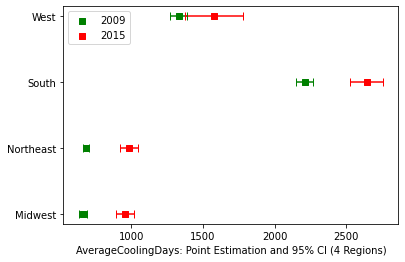

In [59]:
#Q2 part a: 2009 VS 2015 Cooling Days
fig1, ax1 = plt.subplots(nrows=1, ncols=1)
_ = plt.scatter(
    data=ci_cd09,
    x="point_est",
    y="census_re",
    marker='s',
    color='green'
    )
_ = plt.errorbar(
    x=ci_cd09["point_est"],
    y=ci_cd09["census_re"],
    fmt='None',
    xerr=(ci_cd09["sd"] * 1.96, ci_cd09["sd"] * 1.96),
    ecolor='green',
    capsize=4
    )
_ = plt.scatter(
    data=ci_cd15,
    x="point_est",
    y="census_re",
    marker='s',
    color='red'
    )
_ = plt.errorbar(
    x=ci_cd15["point_est"],
    y=ci_cd15["census_re"],
    fmt='None',
    xerr=(ci_cd15["sd"] * 1.96, ci_cd15["sd"] * 1.96),
    ecolor='red',
    capsize=4
    )

_ = ax1.legend(["2009","2015"],loc='upper left') 
_ = ax1.set_xlabel('AverageCoolingDays: Point Estimation and 95% CI (4 Regions)')

This error bar plot consists point estimation and confidence interval of Cooling Days in both 2009 and 2015, we can see 2015 obtain a larger confidence interval for four different regions, simultaneously, 2009 obtain a lower average cooling days than 2015, it may indicates there's a negative sign happens in 2015 during cooling days.

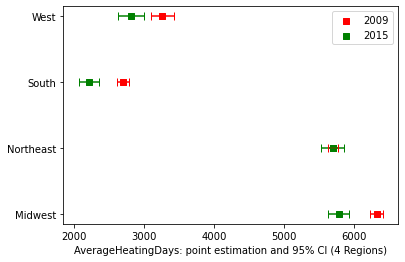

In [60]:
#Q2 Part a: 2009 vs 2015 Heating Days
fig3, ax3 = plt.subplots(nrows=1, ncols=1)
_ = plt.scatter(
    data=ci_hd09,
    x="point_est",
    y="census_re",
    marker='s',
    color='red'
    )
_ = plt.errorbar(
    x=ci_hd09["point_est"],
    y=ci_hd09["census_re"],
    fmt='None',
    xerr=(ci_hd09["sd"] * 1.96, ci_hd09["sd"] * 1.96),
    ecolor='red',
    capsize=4
    )
_ = plt.scatter(
    data=ci_hd15,
    x="point_est",
    y="census_re",
    marker='s',
    color='green'
    )
_ = plt.errorbar(
    x=ci_hd15["point_est"],
    y=ci_hd15["census_re"],
    fmt='None',
    xerr=(ci_hd15["sd"] * 1.96, ci_hd15["sd"] * 1.96),
    ecolor='green',
    capsize=4
)
_ = ax3.legend(["2009","2015"],loc='upper right') 
_ = ax3.set_xlabel('AverageHeatingDays: point estimation and 95% CI (4 Regions)')

This error bar plot consists point estimation and confidence interval of heating days in both 2009 and 2015. Compare with the previous cooling days graph, 2015 is currently having a lower point estimation value in heating days compared to 2009. Therefore, the weather may getting cooler as time passed by.

##### Matplot refers to Q2 part b

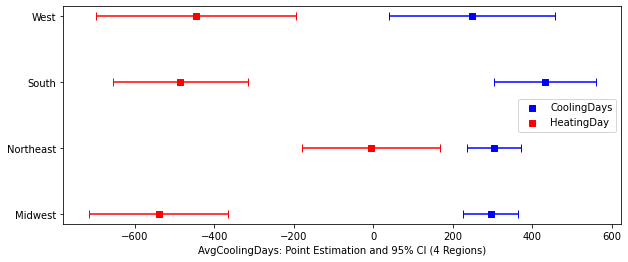

In [62]:
#Q2 Part b: Cooling Days
fig4, ax4 = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
_ = plt.scatter(
    data=table,
    x="point_est_cdd",
    y="census_re",
    marker='s',
    color='blue'
    )
_ = plt.errorbar(
    x=table["point_est_cdd"],
    y=table["census_re"],
    fmt='None',
    xerr=(table["sd_cdd"] * 1.96, table["sd_cdd"] * 1.96),
    ecolor='blue',
    capsize=4
    )
_ = plt.scatter(
    data=table,
    x="point_est_hdd",
    y="census_re",
    marker='s',
    color='red'
    )
_ = plt.errorbar(
    x=table["point_est_hdd"],
    y=table["census_re"],
    fmt='None',
    xerr=(table["sd_hdd"] * 1.96, table["sd_hdd"] * 1.96),
    ecolor='red',
    capsize=4
)
_ = ax4.legend(["CoolingDays","HeatingDay"],loc='right') 
_ = ax4.set_xlabel('AverageCoolingDays: Point Estimation and 95% CI (4 Regions)')

This is the plot of point estimation and confidence interval of difference in 2009 and 2015. We can see the difference is obvious which indicates the weather has a great change.